<a href="https://colab.research.google.com/github/AeroEng16/FootballAnalysis/blob/main/lineDetectionAndHomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:

import math
import plotly.express as px
import pandas as pd
from google.colab.patches import cv2_imshow
try:
  import supervision as sv
  from inference import get_model
except ImportError:
  #!pip install inference
  !pip install supervision
  !pip install inference-gpu
  import supervision as sv
  from inference import get_model
import cv2
import numpy as np
from PIL import Image
import os
import collections
from tqdm import tqdm
#LOOK AT CHANGING TO INFERENCE ON GPU


In [ ]:
# SETUUP FLAGS
DOWNLOADVID = False
SAVEVIDPARTS = False

#TRY AND IMPLEMENT THE METHOD IN ONE OF THESE PAPERS FOR THE HOMOGRAPHY AS
#PLAYER AND BALL DETECTION ISNT BAD FROM THE NEURAL NET BUT THE
#KEY POINT DETECTION ISN'T GREAT

#https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8354144
#https://www.sciencedirect.com/science/article/pii/S0957417424010224

In [69]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
#!pip install SoccerNet --upgrade

#import SoccerNet
#from SoccerNet.Downloader import SoccerNetDownloader
#mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="sample_data")

#mySoccerNetDownloader.downloadDataTask(task="calibration", split=["train","valid","test","challenge"])
#mySoccerNetDownloader.downloadDataTask(task="calibration-2023", split=["train","valid","test","challenge"])
#!cp /content/sample_data/calibration-2023/test.zip /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/.
#!cp /content/sample_data/calibration-2023/train.zip /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/.
#!cp /content/sample_data/calibration-2023/valid.zip /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/.

try:
  import patoolib
except ModuleNotFoundError:
  !pip install patool
  import patoolib

patoolib.extract_archive("/content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip",outdir="homographyValidData")
patoolib.extract_archive("/content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/test.zip",outdir="homographyTestData")
patoolib.extract_archive("/content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/train.zip",outdir="homographyTrainData")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 4.4 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip ...
INFO:patool:Extracting /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip ...
INFO patool: ... creating output directory `homographyValidData'.
INFO:patool:... creating output directory `homographyValidData'.
INFO patool: running /usr/bin/7z x -aou -ohomographyValidData -- /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip
INFO:patool:running /usr/bin/7z x -aou -ohomographyValidData -- /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip
INFO patool: ... /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip extracted to `homographyValidData'.
INFO:patool:... /content/drive/MyDrive/ML/FootballAnalysis/Data/HomographyDataset/valid.zip extracted to `homographyValidData'.


'homographyValidData'

## Pitch Utility Functions

Figure out how pitch config works and recreate alongside template image

In [ ]:


#!pip install -q git+https://github.com/roboflow/sports.git


from dataclasses import dataclass, field
from typing import List, Tuple


@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])

CONFIG = SoccerPitchConfiguration()


In [ ]:
from typing import Optional, List

import cv2
import supervision as sv
import numpy as np


def draw_pitch(
    config: SoccerPitchConfiguration,
    background_color: sv.Color = sv.Color(34, 139, 34),
    line_color: sv.Color = sv.Color.WHITE,
    padding: int = 50,
    line_thickness: int = 4,
    point_radius: int = 8,
    scale: float = 0.1
) -> np.ndarray:
    """
    Draws a soccer pitch with specified dimensions, colors, and scale.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        background_color (sv.Color, optional): Color of the pitch background.
            Defaults to sv.Color(34, 139, 34).
        line_color (sv.Color, optional): Color of the pitch lines.
            Defaults to sv.Color.WHITE.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        line_thickness (int, optional): Thickness of the pitch lines in pixels.
            Defaults to 4.
        point_radius (int, optional): Radius of the penalty spot points in pixels.
            Defaults to 8.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.

    Returns:
        np.ndarray: Image of the soccer pitch.
    """
    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)
    scaled_circle_radius = int(config.centre_circle_radius * scale)
    scaled_penalty_spot_distance = int(config.penalty_spot_distance * scale)

    pitch_image = np.ones(
        (scaled_width + 2 * padding,
         scaled_length + 2 * padding, 3),
        dtype=np.uint8
    ) * np.array(background_color.as_bgr(), dtype=np.uint8)

    for start, end in config.edges:
        point1 = (int(config.vertices[start - 1][0] * scale) + padding,
                  int(config.vertices[start - 1][1] * scale) + padding)
        point2 = (int(config.vertices[end - 1][0] * scale) + padding,
                  int(config.vertices[end - 1][1] * scale) + padding)
        cv2.line(
            img=pitch_image,
            pt1=point1,
            pt2=point2,
            color=line_color.as_bgr(),
            thickness=line_thickness
        )

    centre_circle_center = (
        scaled_length // 2 + padding,
        scaled_width // 2 + padding
    )
    cv2.circle(
        img=pitch_image,
        center=centre_circle_center,
        radius=scaled_circle_radius,
        color=line_color.as_bgr(),
        thickness=line_thickness
    )

    penalty_spots = [
        (
            scaled_penalty_spot_distance + padding,
            scaled_width // 2 + padding
        ),
        (
            scaled_length - scaled_penalty_spot_distance + padding,
            scaled_width // 2 + padding
        )
    ]
    for spot in penalty_spots:
        cv2.circle(
            img=pitch_image,
            center=spot,
            radius=point_radius,
            color=line_color.as_bgr(),
            thickness=-1
        )

    return pitch_image


def draw_points_on_pitch(
    config: SoccerPitchConfiguration,
    xy: np.ndarray,
    face_color: sv.Color = sv.Color.RED,
    edge_color: sv.Color = sv.Color.BLACK,
    radius: int = 10,
    thickness: int = 2,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws points on a soccer pitch.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        xy (np.ndarray): Array of points to be drawn, with each point represented by
            its (x, y) coordinates.
        face_color (sv.Color, optional): Color of the point faces.
            Defaults to sv.Color.RED.
        edge_color (sv.Color, optional): Color of the point edges.
            Defaults to sv.Color.BLACK.
        radius (int, optional): Radius of the points in pixels.
            Defaults to 10.
        thickness (int, optional): Thickness of the point edges in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw points on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with points drawn on it.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    for point in xy:
        scaled_point = (
            int(point[0] * scale) + padding,
            int(point[1] * scale) + padding
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )

    return pitch


def draw_paths_on_pitch(
    config: SoccerPitchConfiguration,
    paths: List[np.ndarray],
    color: sv.Color = sv.Color.WHITE,
    thickness: int = 2,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws paths on a soccer pitch.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        paths (List[np.ndarray]): List of paths, where each path is an array of (x, y)
            coordinates.
        color (sv.Color, optional): Color of the paths.
            Defaults to sv.Color.WHITE.
        thickness (int, optional): Thickness of the paths in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw paths on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with paths drawn on it.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    for path in paths:
        scaled_path = [
            (
                int(point[0] * scale) + padding,
                int(point[1] * scale) + padding
            )
            for point in path if point.size > 0
        ]

        if len(scaled_path) < 2:
            continue

        for i in range(len(scaled_path) - 1):
            cv2.line(
                img=pitch,
                pt1=scaled_path[i],
                pt2=scaled_path[i + 1],
                color=color.as_bgr(),
                thickness=thickness
            )

        return pitch


def draw_pitch_voronoi_diagram(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    control_mask = min_distances_team_1 < min_distances_team_2

    voronoi[control_mask] = team_1_color_bgr
    voronoi[~control_mask] = team_2_color_bgr

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

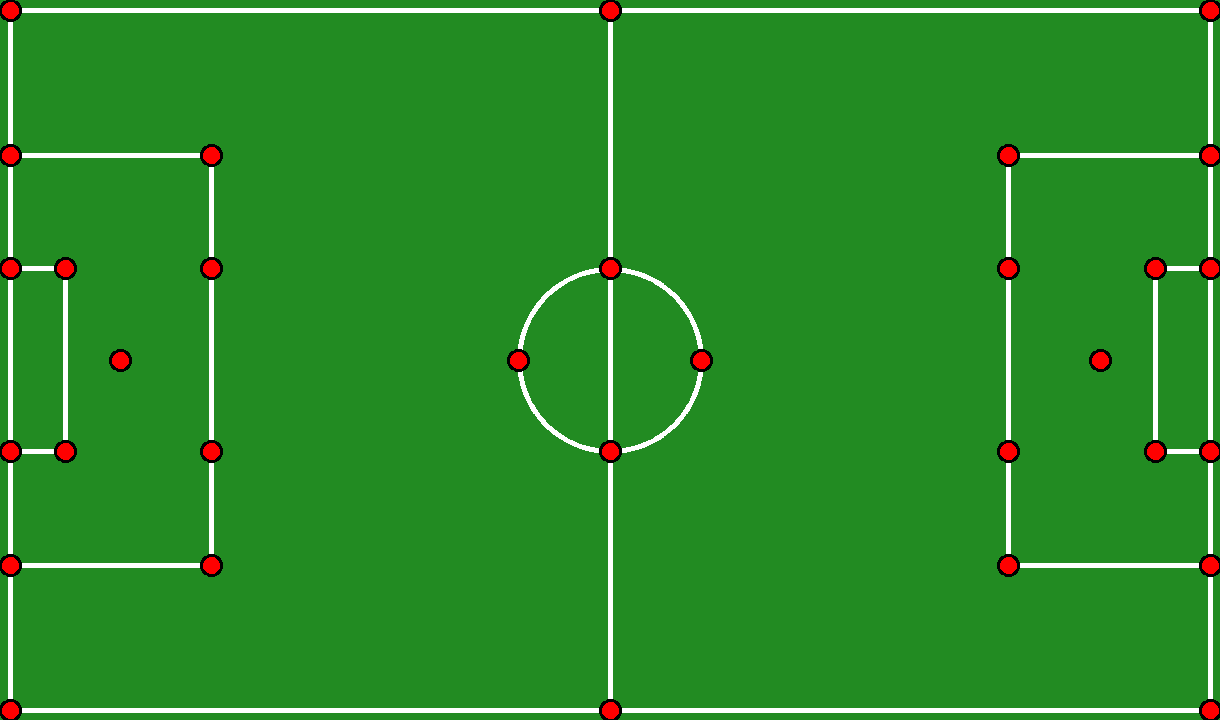

In [ ]:
cv2_imshow(draw_points_on_pitch(CONFIG,CONFIG.vertices,padding=10))

## Assign homography training data to numbered points

In [ ]:

#FIGURE OUT HOW TO EXTRACT LIST OF KEYPOINT NAMES TO ASSOCIATE WITH LOCAITONS ON pitchDimensions
#THEN IMPLEMENT THIS https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8354144
import os
import json

from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

files = os.listdir("homographyTrainData/train")

files = [file for file in files if "json" in file and "match_info" not in file]
keyList = []
for file in files:
  # Opening JSON file
  f = open("homographyTrainData/train/"+file)

  # returns JSON object as a dictionary
  jsondata = json.load(f)
  currentKeys = list(jsondata.keys())
  keyList.append(currentKeys)
from itertools import chain

pointDescriptions = (list(set(chain(*keyList))))


FileNotFoundError: [Errno 2] No such file or directory: 'homographyTrainData/train'

## Import video if needed

In [ ]:
#FIGURE OUT WHY THE FIRST PART OF THE INTER JUVE GAME KEY POINTS ARE OFF, THINK IT MIGHT BE A VIDEO SHAPE PROBLEM

if DOWNLOADVID:
  try:
    from pytubefix import YouTube
    from pytubefix.cli import on_progress
  except ModuleNotFoundError:
    !pip install pytubefix
    from pytubefix import YouTube
    from pytubefix.cli import on_progress

  url = 'https://www.youtube.com/watch?v=PEvflD64RnE'

  yt = YouTube(url, on_progress_callback=on_progress)
  ys = yt.streams.get_highest_resolution()
  ys.download(output_path="test")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.6 MB/s eta 0:00:00


'/content/test/CLASSIC CLASH - FULL MATCH | INTER 2-0 JUVENTUS | SEASON 2021 ⚫🔵🇮🇹.mp4'

In [ ]:
if SAVEVIDPARTS:

  cap = cv2.VideoCapture("//content/test/CLASSIC CLASH - FULL MATCH | INTER 2-0 JUVENTUS | SEASON 2021 ⚫🔵🇮🇹.mp4")

  fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  duration = frame_count/fps

  fps, frame_count, duration

  # 16:40 (1000s) - 17:10 (1030s) - first goal
  # 59:00 (3540s) - 59:40 (3580s) - second goal

  parts = [(1000*25,1030*25),(3540*25,3580*25)]

  ret, frame = cap.read()
  h, w, _ = frame.shape

  ## Define 4 character code for video type (avi in this case) and setup a video writer for each part

  fourcc = cv2.VideoWriter_fourcc(*"XVID")
  writers = [cv2.VideoWriter(f"/content/drive/MyDrive/ML/FootballAnalysis/InterJuvepart{start}-{end}.avi", fourcc, 20.0, (w, h)) for start, end in parts]

  f = 0
  while ret:
      f += 1

      #WRITE PART to appropriate writer
      for i, (start, end) in enumerate(parts):
          if start <= f <= end:
              writers[i].write(frame)
      ret, frame = cap.read()

  for writer in writers:
      writer.release()

  cap.release()

ZeroDivisionError: float division by zero

## Detect Players and Ball and Use detected keypoints to transform

In [ ]:


#Setup class to conduct the homography transformation

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                "Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)


### Initiliase the three models used

In [ ]:

model = get_model(
    model_id="football-field-detection-f07vi/14",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

ballModel = get_model(
    model_id="football-ball-detection-rejhg/4",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)

playerModel = get_model(
    model_id="football-players-detection-3zvbc/12",
    api_key="Sjv2KA46fn0Ksxphg6NV"
)



### Calculate the detections and kit color for each frame

In [ ]:
#CHANGE HOW THE LOCATION AND COLORS ARE SAVED SO THEY ARE SAVED AS A LIST

# Loop through frames, identifying objects and moving to flat pitch view view
#homography transform and saving in df
#vid = cv2.VideoCapture("/content/drive/MyDrive/ML/FootballAnalysis/08fd33_4.mp4")
vid = cv2.VideoCapture("/content/drive/MyDrive/ML/FootballAnalysis/InterJuvepart88500-89500.avi")

vidLength = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

## Initiliase dataframe to store detections

df = pd.DataFrame(data=None,columns=["Frame","Ball Location","PlayerDicts"])

kits_colors = []

for i in tqdm(range(vidLength)):
#while True:

  if i > 5000:
    break
  if i>0:
    if ret == False:
      break
  ret, frame = vid.read()
  height,width,channels = frame.shape
  if i ==0:
    ### First calculate the color of the grass

    # Convert image to HSV color space
    img = frame.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define a large range of green color in HSV
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Calculate the mean value of the pixels that are not masked
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    grass_color = cv2.mean(img, mask=mask)
    grass_color = grass_color[:3]
    #print("Grass BGR color: ", grass_color)


  #image = cv2.imread("test.png")
  image = frame
  # KeyPointDetections
  result = model.infer(image, confidence=0.3)[0]

  keypoints = sv.KeyPoints.from_inference(result)
  try:
    filter = keypoints.confidence[0] > 0.5
  except TypeError:
    img = np.zeros((height, width, channels), dtype = np.uint8)
    im = Image.fromarray(img)
    im.save("annotatedImage" + str(i) +".png")
    continue

  keypoints.xy = keypoints.xy[0][filter][np.newaxis]
  keypoints.confidence = keypoints.confidence[0][filter][np.newaxis]

  vertex_annotator = sv.VertexAnnotator(radius=5)
  annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

  if len(keypoints.xy[0]) < 6:
    img = np.zeros((height, width, channels), dtype = np.uint8)
    im = Image.fromarray(img)
    im.save("annotatedImage" + str(i) +".png")
    continue

  transformer = ViewTransformer(
      target=np.array(CONFIG.vertices)[filter].astype(np.float32),
      source=np.array(keypoints.xy[0].astype(np.float32),)
  )

  #Ball Detection

  resultBall = ballModel.infer(image, confidence=0.5)[0]

  detectionsBall = sv.Detections.from_inference(resultBall)

  EllipseAnnotator_annotatorBall = sv.EllipseAnnotator(thickness=2)
  annotated_imageBall = EllipseAnnotator_annotatorBall.annotate(annotated_image.copy(), detectionsBall)

  xyBall = detectionsBall.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  xyBall = transformer.transform_points(points=xyBall)


  #Player Detection

  resultPlayer = playerModel.infer(image, confidence=0.7)[0]

  detectionsPlayer = sv.Detections.from_inference(resultPlayer)

  xyPlayers = detectionsPlayer.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

  EllipseAnnotator_annotatorPlayer = sv.EllipseAnnotator(thickness=2)
  annotated_imagePlayer = EllipseAnnotator_annotatorPlayer.annotate(annotated_imageBall.copy(), detectionsPlayer)
  im = Image.fromarray(annotated_imagePlayer)
  im.save("annotatedImage" + str(i) +".png")

  ### Work out kit color


#ADD A CHECK THAT IF ALL OF IMAGE IS MASKED THEN SET KIT COLOUR TO GREEN (or better way of dealing with this)

  filterPlayer = detectionsPlayer.data["class_name"]  == "player"
  filterGk = detectionsPlayer.data["class_name"]  == "goalkeeper"


  xyPlayers = xyPlayers[filterPlayer]
  xyPlayers = transformer.transform_points(points=xyPlayers)

  playerBoxes = detectionsPlayer.xyxy[filterPlayer]
  gkBoxes = detectionsPlayer.xyxy[filterGk]

  grass_hsv = cv2.cvtColor(np.uint8([[list(grass_color)]]), cv2.COLOR_BGR2HSV)
  playerDict = {}
  for counter,box in enumerate(playerBoxes):

      x1, y1, x2, y2 = map(int, box)
      player_img = frame[y1: y2, x1: x2]

      pixels = np.float32(player_img.reshape(-1, 3))

      n_colors = 2
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
      flags = cv2.KMEANS_RANDOM_CENTERS

      _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
      _, counts = np.unique(labels, return_counts=True)

      player_kit_color = list(palette[np.argmin(counts)])

      playerDict[counter] = {"kitColor": player_kit_color,"location": list(xyPlayers[counter])}
      kits_colors.append(player_kit_color)
      #CHECK THE LOCATION ABOVE IS THE BOTTOM MIDDLE COORDINATE

  ## Add data for current frame to df

  df.loc[i]= [i, xyBall, playerDict]

df.to_csv("transformedData_interJuve.csv")



 75%|███████▍  | 746/1001 [04:02<01:07,  3.77it/s]Exception in thread Thread-12 (_usage_sender):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/collector.py", line 450, in _usage_sender
    self._flush_queue()
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/collector.py", line 458, in _flush_queue
    merged_payloads: APIKeyUsage = zip_usage_payloads(
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/payload_helpers.py", line 123, in zip_usage_payloads
    merged_api_key_payload[resource_usage_key] = merge_usage_dicts(
  File "/usr/local/lib/python3.10/dist-packages/inference/usage_tracking/payload_helpers.py", line 21, in merge_usage_dicts
    raise ValueError("Cannot merge usage for di

## Workflow for calculating homogrpahy

Image with player detections


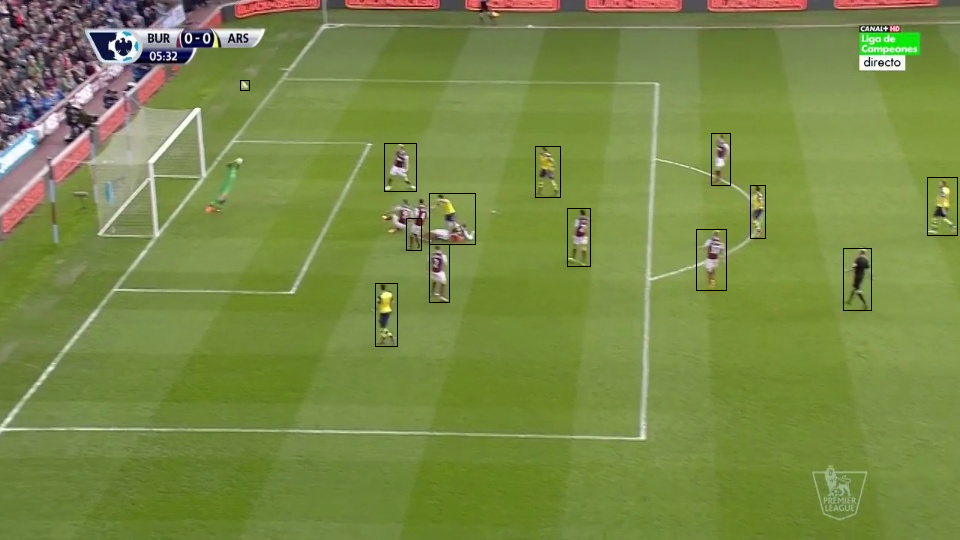

Image with grass and players masked


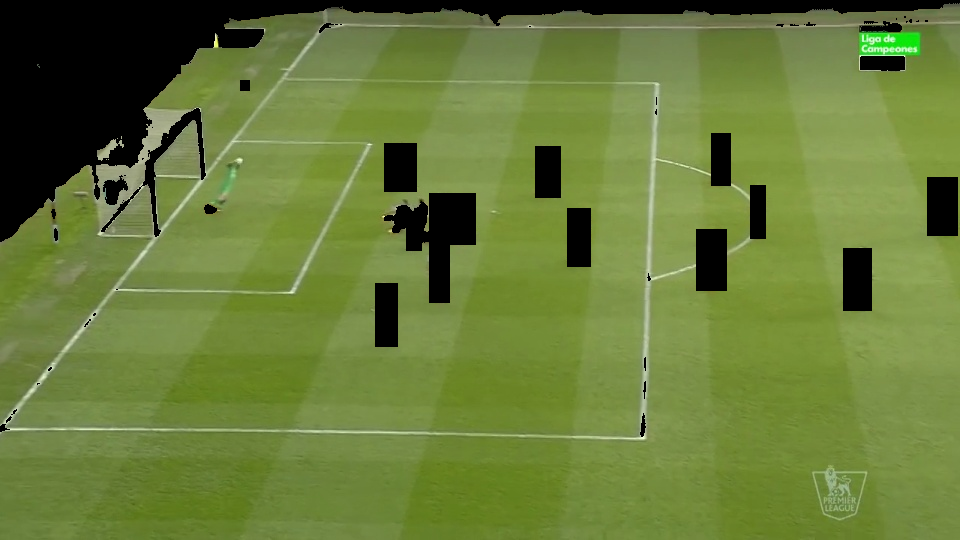

Edges detected from masked image


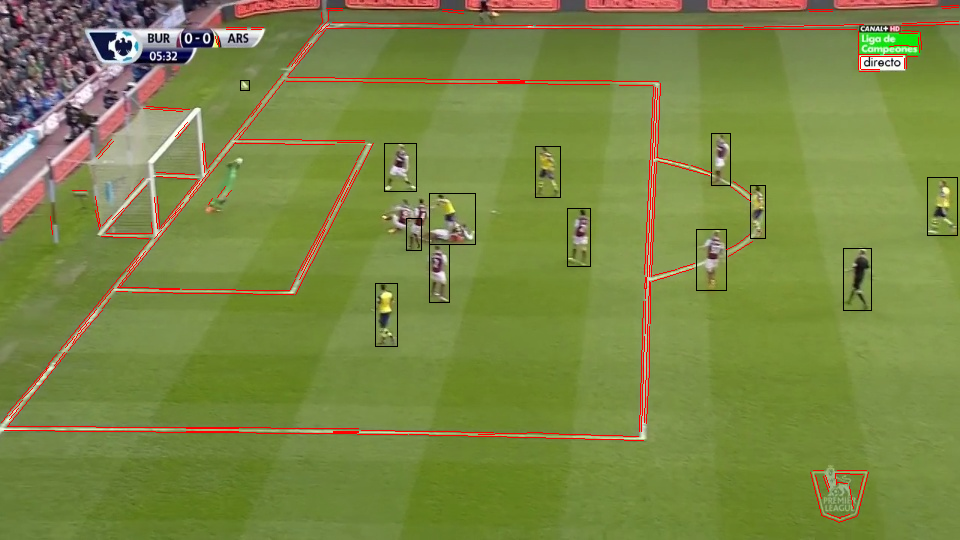

In [70]:
image = cv2.imread('/content/homographyValidData/valid/00005.jpg')
#cv2_imshow(image)

# Convert image to HSV color space
img = image.copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define a large range of green color in HSV
lower_green = np.array([30, 40, 40])
upper_green = np.array([80, 255, 255])

# Player detections to exclude edges from

resultPlayer = playerModel.infer(image, confidence=0.7)[0]

detectionsPlayer = sv.Detections.from_inference(resultPlayer)

playerBoxes = detectionsPlayer.xyxy

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)

#mask = np.zeros((height,width))
for bbox in playerBoxes:
    x1, y1, x2, y2 = bbox
    img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)),(0,0,0))
    mask = cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,0), -1)
#mask = ((mask>=1)*255.0).astype(np.uint8)
print("Image with player detections")
cv2_imshow(img)
# Calculate the mean value of the pixels that are not masked
masked_img = cv2.bitwise_and(img, img, mask=mask)
print("Image with grass and players masked")
cv2_imshow(masked_img)
edges = cv2.Canny(image,50,200)
edges = cv2.bitwise_and(edges, edges, mask=mask)

# Line segment detection
lsd = cv2.createLineSegmentDetector(0)

lines_lsd = lsd.detect(edges)[0]
drawn_img = lsd.drawSegments(img,lines_lsd)

print("Edges detected from masked image")
cv2_imshow(drawn_img)




In [86]:
import numpy as np
import math
import plotly.graph_objects as go

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

angles = []

for line in lines_lsd:
    line = line[0]
    currentVector = [line[2]-line[0],line[3]-line[1]]
    unitVector = unit_vector(currentVector)
    angles.append(math.degrees(angle_between(unitVector, [1,0])))

hist,bins = np.histogram(angles,bins=20)



fig = go.Figure(go.Barpolar(
    r=hist,
    theta=[x+4.5 for x in bins],
    width=9,
    #marker_color=["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4'],
    marker_line_color="black",
    marker_line_width=2,
    opacity=0.8
))
fig.show()

In [ ]:
kits_kmeans.cluster_centers_

array([[  0.93041456],
       [-24.919462  ]], dtype=float32)

## Example of using kmeans and bounding boxes to determine kit color


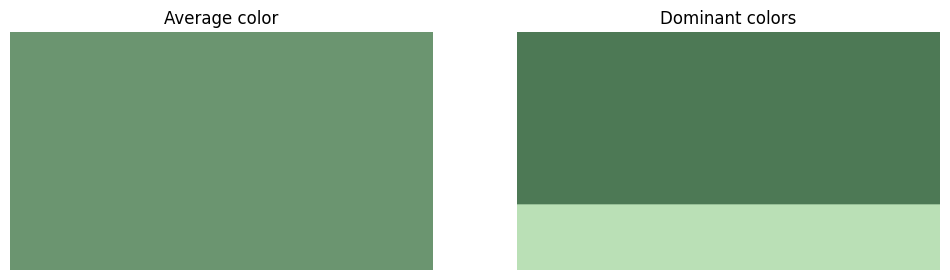

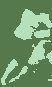

In [ ]:

      player_img = frame[y1: y2, x1: x2]

      average = player_img.mean(axis=0).mean(axis=0)

      pixels = np.float32(player_img.reshape(-1, 3))

      n_colors = 2
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
      flags = cv2.KMEANS_RANDOM_CENTERS

      _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
      _, counts = np.unique(labels, return_counts=True)

      player_kit_color = list(palette[np.argmin(counts)])

      import matplotlib.pyplot as plt

      avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

      indices = np.argsort(counts)[::-1]
      freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
      rows = np.int_(img.shape[0]*freqs)

      dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
      for i in range(len(rows) - 1):
          dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

      fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
      ax0.imshow(avg_patch)
      ax0.set_title('Average color')
      ax0.axis('off')
      ax1.imshow(dom_patch)
      ax1.set_title('Dominant colors')
      ax1.axis('off')
      plt.show(fig)

      palette = np.uint8(palette)
      res = palette[labels.flatten()]
      res2 = res.reshape((player_img.shape))
      cv2_imshow(res2)

## Use K-means clustering to determine what team each player detection belongs to

### Finally, based on the kit colors, calculate a k-means clustering to place the player detections in the relevant team

In [ ]:

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kits_kmeans = KMeans(n_clusters=2)
kits_kmeans.fit(kits_colors);

kits_colors = np.array(kits_colors)

import plotly.express as px

fig = px.scatter_3d(
    x=kits_colors[:, 2],
    y=kits_colors[:, 1],
    z=kits_colors[:, 0],
    range_x=[0, 255],
    range_y=[0, 255],
    range_z=[0, 255],
    title="Kits Colors"
    )
fig.update_traces(marker_size = 4)
#fig.update_traces(marker_color = list(map(lambda e: (e[2], e[1], e[0]), kits_colors)))
fig.update_traces(marker_color = list(map(lambda e: 'rgba('+str(e[0])+','+str(e[1])+','+str(e[2])+',0.75)', kits_colors)))

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[0, 2]],
    y=[kits_kmeans.cluster_centers_[0, 1]],
    z=[kits_kmeans.cluster_centers_[0, 0]],
    marker_size = 20
)

fig.add_scatter3d(
    x=[kits_kmeans.cluster_centers_[1, 2]],
    y=[kits_kmeans.cluster_centers_[1, 1]],
    z=[kits_kmeans.cluster_centers_[1, 0]],
    marker_size = 20
)

for i, d in enumerate(fig.data[-2:]):
  d.marker.symbol='cross'
  d.marker.color=kits_kmeans.cluster_centers_[i, ::-1]

fig.show()



### Assign players into teams based on calculated k-means cluster

In [ ]:
kits_kmeans.cluster_centers_ = kits_kmeans.cluster_centers_.astype(np.float32)
for key in df.iloc[0].PlayerDicts.keys():
  print(df.iloc[0].PlayerDicts[key]["kitColor"])
  print(kits_kmeans.predict(np.array(df.iloc[0].PlayerDicts[key]["kitColor"]).reshape(1,-1)))

  #kits_kmeans.predict(player_kit_color)


[152.65958, 233.52765, 173.50212]
[0]
[229.70627, 232.41776, 226.68538]
[1]
[148.50131, 225.77547, 169.87337]
[0]
[151.42253, 238.09038, 189.6162]
[0]
[155.36603, 239.82869, 177.34554]
[0]
[129.7507, 225.45024, 157.9365]
[0]
[227.82968, 228.09276, 212.05397]
[1]
[160.42322, 237.1125, 182.13571]
[0]
[225.05785, 231.37602, 220.07437]
[1]
[205.40439, 203.33069, 191.75499]
[1]
[224.96895, 229.49797, 214.85695]
[1]
[149.38661, 237.00084, 177.51883]
[0]
[215.8369, 221.71793, 204.62033]
[1]
[208.06667, 210.62465, 206.63562]
[1]
[146.00249, 228.58984, 171.4742]
[0]
[220.17786, 224.7143, 211.2624]
[1]
[162.16954, 236.14081, 182.11494]
[0]
[221.57558, 221.26454, 211.40407]
[1]
[186.78732, 224.22954, 182.85474]
[1]


## Loop through rest of frames and assign bounding boxes to each team

In [ ]:
import pandas as pd
import ast
url = "https://raw.githubusercontent.com/AeroEng16/FootballAnalysis/refs/heads/main/transformedData.csv"
df = pd.read_csv(url,usecols=[1,2,3])
df.PlayerDicts = df.PlayerDicts.apply(ast.literal_eval)

In [ ]:
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
pitchImage = Image.open("/content/drive/MyDrive/ML/FootballAnalysis/pitch_template.png")
pitchTemplate = np.float32(pitchImage)


pitchImageDimensions = (pitchTemplate.shape[0],pitchTemplate.shape[1])
pitchDimensions = (CONFIG.width,CONFIG.length)
#cv2_imshow(pitchImage)

for i in range(len(df.index)):

  pitchImage = pitchTemplate.copy()

  positions = [df.iloc[i].PlayerDicts[x]['location'] for x in df.iloc[i].PlayerDicts.keys()]

  mappedLocations = [[x[0]*pitchImageDimensions[0]/pitchDimensions[0],x[1]*pitchImageDimensions[1]/pitchDimensions[1]] for x in positions]

  for loc in mappedLocations:

    pitchImage=cv2.circle(pitchImage,tuple([int(loc[0]),int(loc[1])]),int(3),(255,0,0),-1)
  #cv2_imshow(pitchImage)
  pitchImage = pitchImage*255
  pitchImage = pitchImage.astype(np.uint8)
  pitchImagePNG = Image.fromarray(pitchImage)
  pitchImagePNG.save("annotatedPitchImage" + str(i) +".png")


#cv2_imshow(pitchImage)

KeyboardInterrupt: 

## Save videos of annotated broadcast footage and associated 2D pitch view

In [ ]:
def save():
    os.system("ffmpeg -r 30 -i annotatedImage%01d.png -vcodec mpeg4 -y amovie.mp4")

save()


In [ ]:
def save():
    os.system("ffmpeg -r 30 -i annotatedPitchImage%01d.png -vcodec mpeg4 -y movie.mp4")

save()

## Own trained model via transfer learning

In [ ]:
try:
  from ultralytics import YOLO
except ModuleNotFoundError:
  !pip install ultralytics
  from ultralytics import YOLO

# Load a pretrained YOLO11n model
modelPlayers = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestFootballYoloSoFar.pt")

# Run inference on 'bus.jpg' with arguments
modelPlayers.predict("test.png", save=True, conf=0.5)

modelBall = YOLO("/content/drive/MyDrive/ML/FootballAnalysis/Models/bestBallSoFar_0409.pt")

modelBall.predict("test.png", save=True, conf=0.1)


image 1/1 /content/test.png: 384x640 23 players, 1 referee, 315.0ms
Speed: 4.0ms preprocess, 315.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

image 1/1 /content/test.png: 384x640 2 balls, 5236.3ms
Speed: 8.5ms preprocess, 5236.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'ball'}
 obb: None
 orig_img: array([[[105, 146, 100],
         [ 98, 139,  93],
         [101, 150,  97],
         ...,
         [ 82,  92, 100],
         [ 85,  95, 103],
         [ 87,  97, 105]],
 
        [[104, 145,  99],
         [105, 146, 100],
         [114, 163, 110],
         ...,
         [ 87,  97, 105],
         [ 89,  99, 107],
         [ 90, 100, 108]],
 
        [[101, 150,  97],
         [110, 159, 106],
         [115, 172, 114],
         ...,
         [ 88,  98, 106],
         [ 90, 100, 108],
         [ 92, 102, 110]],
 
        ...,
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 43,  47,  30],
         [ 44,  48,  31],
         [ 44,  48,  31]],
 
        [[ 78, 103,  74],
         [ 78, 103,  74],
         [ 78, 103,  74],
         ...,
         [ 55,  56, 